Import necessary libraries

In [45]:
#import streamlit as st 
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

#from streamlit_lottie 
import json

In [46]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


We see some missing values located on director,cast, country and date added features. And also rating feature includes 4, duration feature includes 3 missing values

EDA

In [48]:
netflix_shows=df[df['type']=='TV Show']
netflix_movies=df[df['type']=='Movie']

Ratings

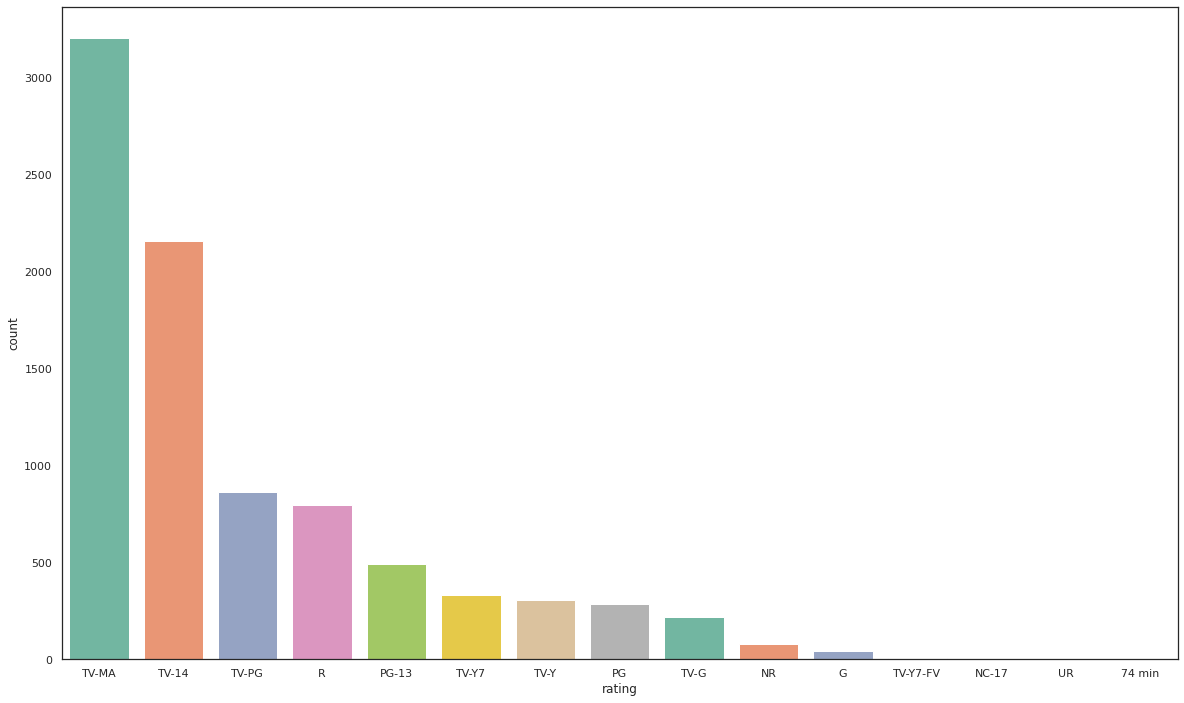

In [49]:
plt.figure(figsize=(20,12))
sns.set(style="white")
ax = sns.countplot(x="rating", data=df, palette="Set2", order=df['rating'].value_counts().index[0:15])

By this countplot of ratings we can realize that TV-MA ( Mature Audiences ) contents have the highest rating numbers. Then it gets lower as in order TV-14 ( Material that parents or adult guardians may find unsuitable for children under the age of 14 ) and TV-PG ( Parental Guideness

Year

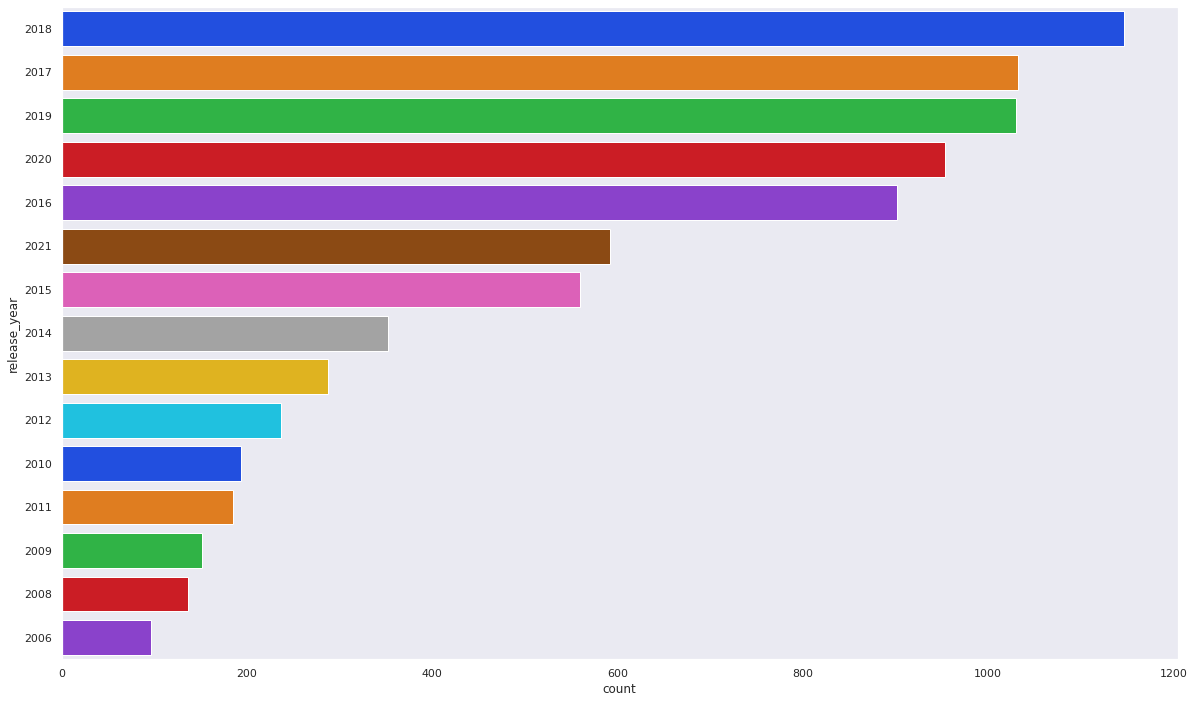

In [50]:
plt.figure(figsize=(20,12))
sns.set(style="dark")
ax = sns.countplot(y="release_year", data=df, palette="bright", order=df['release_year'].value_counts().index[0:15])

This plot shows that most of the contents were produced in 2018 and 2017. Interesting fact is in 2019, 2020 and 2021 the number of produced contents are low. This is mostly because Covid-19 pandemic

we need only these two column form above dataset for building the recommendation system

In [51]:
df[['title','description']]

,title,description
0,Dick Johnson Is Dead,"As her father nears the end of his life, filmm..."
1,Blood & Water,"After crossing paths at a party, a Cape Town t..."
2,Ganglands,To protect his family from a powerful drug lor...
3,Jailbirds New Orleans,"Feuds, flirtations and toilet talk go down amo..."
4,Kota Factory,In a city of coaching centers known to train I...
...,...,...
8802,Zodiac,"A political cartoonist, a crime reporter and a..."
8803,Zombie Dumb,"While living alone in a spooky town, a young g..."
8804,Zombieland,Looking to survive in a world taken over by zo...
8805,Zoom,"Dragged from civilian life, a former superhero..."


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
netflix_data = df.copy()
tfidf = TfidfVectorizer(stop_words='english')
netflix_data['description'] = netflix_data['description'].fillna('')
tfidf_matrix=tfidf.fit_transform(netflix_data['description'])


The Cosine similarity score is used since it is independent of magnitude and is relatively easy and fast to calculate

In [53]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)
cosine_sim


array([[1.        , 0.        , 0.        , ..., 0.        , 0.01538292,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.02230089],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.01538292, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.02230089, ..., 0.        , 0.        ,
        1.        ]])

In [54]:
indices=pd.Series(netflix_data.index,index=netflix_data['title']).drop_duplicates()
indices

title
Dick Johnson Is Dead        0
Blood & Water               1
Ganglands                   2
Jailbirds New Orleans       3
Kota Factory                4
                         ... 
Zodiac                   8802
Zombie Dumb              8803
Zombieland               8804
Zoom                     8805
Zubaan                   8806
Length: 8807, dtype: int64

Recommendation System using cosine similarity 
The scores which are closer to the chosen movie are listed in count of 10

In [55]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return netflix_data[['title','description']].iloc[movie_indices]

In [57]:
get_recommendations('Sankofa')

,title,description
8353,The Hunt,Witness some of the most riveting showdowns in...
7037,I Am Jane Doe,This intense documentary follows real cases of...
5580,One More Time,This fantasy drama follows an indie band singe...
5653,My Runway,An egotistic top male model and a pretty model...
3619,I'm Brent Morin,"In a witty solo show, Brent Morin serves up in..."
2824,The Valhalla Murders,An Oslo detective with a painful past returns ...
4056,Losers,"In a ""winning is everything"" society, how do w..."
5044,When We First Met,Using a magical photo booth that sends him bac...
5013,Something Huge,"A director and a comedian want to shoot the ""c..."
7700,Palm Trees in the Snow,"Finding a tantalizing clue in an old letter, a..."


App Layout

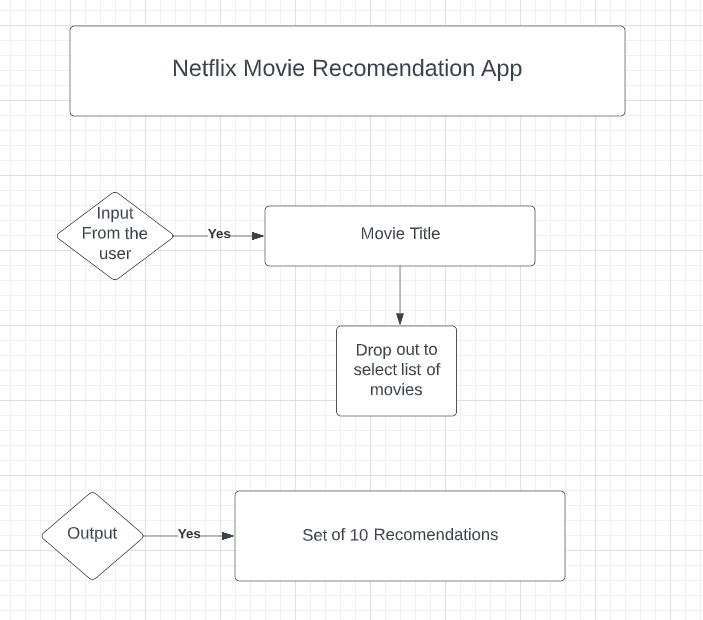

adding title
# st.header(Netflix Movie Recommendation System )
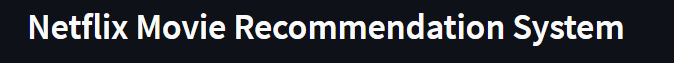
adding selectbox

#movie_list = netflix_data['title'].values
#movie_list # list of all movies in our dataset
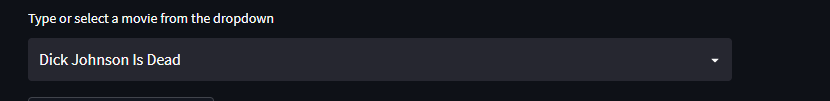
adding button
#if st.button('Show Recommendation')
#recommended_movie_names = get_recommendations(selected_movie)
#recommended_movie_name
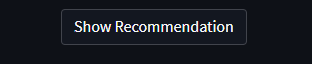
#adding customized elements to streamlit
#using plotly table inside streamlit app
#Please check the code in detail here
#https://github.com/Ruthwik333/Netflix-Movie-Recommendation-App/blob/main/app.py
Deployed App link
#https://ruthwik333-netflix-movie-recommendation-app-app-hyy0vu.streamlitapp.com/
#Please Upvote if you like
Thank you



Final App Interface

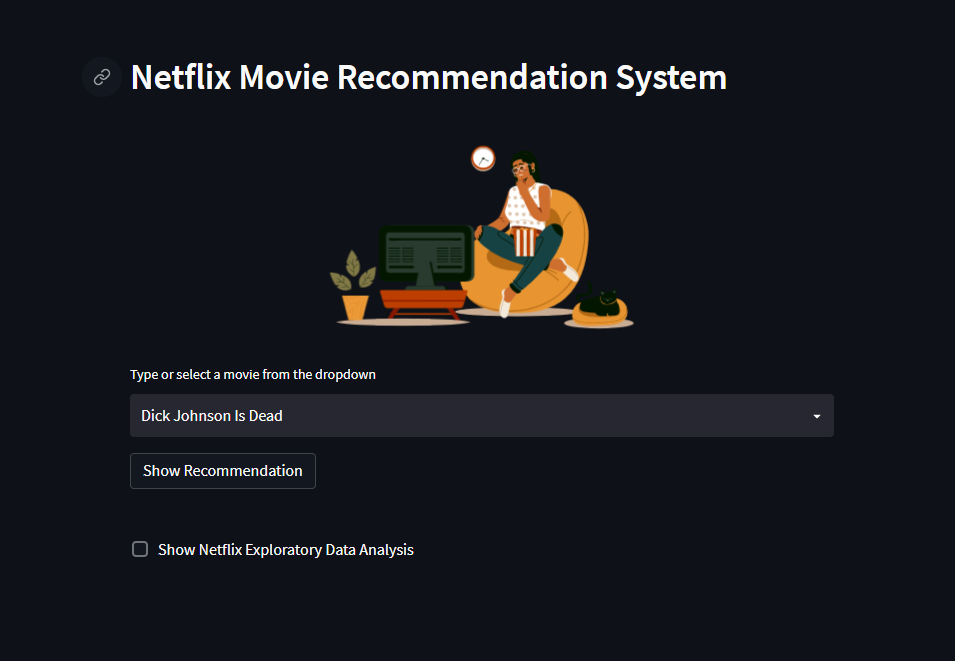


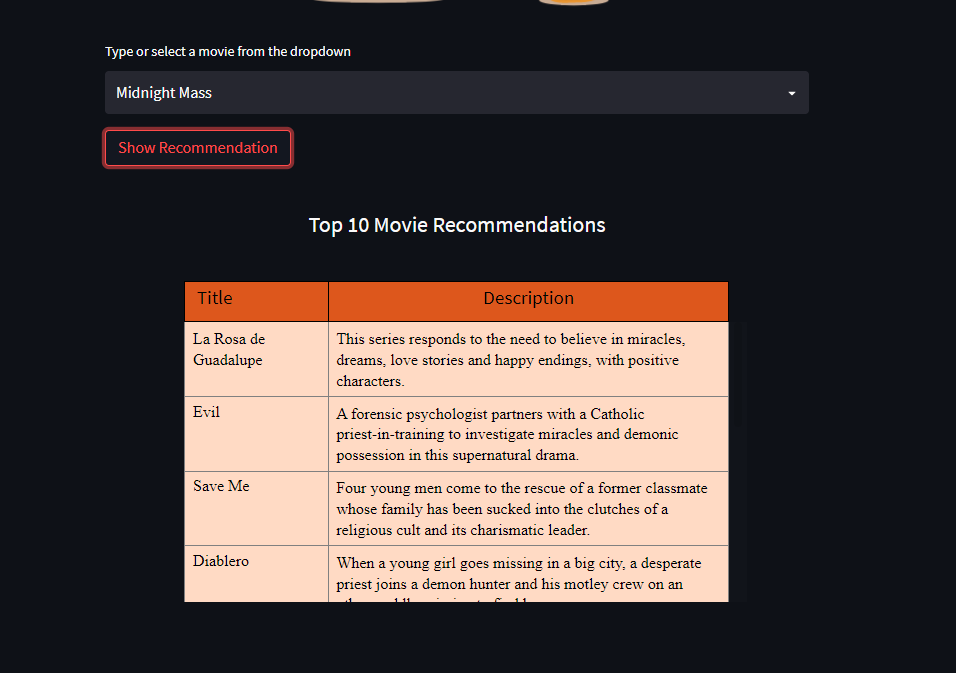